In [1]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column,row
from bokeh.models import Div
from bokeh.palettes import Spectral6
from bokeh.io import export_svg

import json
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

import os

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

output_notebook();

Loading BokehJS ...

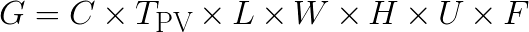

where G is the expected performance in GFLOP/s
- C is the number of cores per socket
- B is the base frequency for scalar workloads (the number that you will find in most documents)
- T<sub>S</sub> is the maximum Turbo frequency for scalar workloads on 1 core,
- T<sub>PS</sub> is for scalar workloads on C cores, and
- T<sub>PV</sub> is for AVX-512 workloads on C cores. Clock frequencies are in GHz.
- L is the number of sockets
- W is the vector width (W=16 for single precision, W=8 for double precision)
- H is the throughput of the instruction (H=1 instruction per cycle for addition, multiplication, subtraction and FMA)
- U is the number of FMA units (U=2 for Platinum 81xx and Gold 61xx processors, U=1 for all others)
- F is the number of FLOPs per instruction (F=2 for FMA and F=1 for all other instructions).




https://colfaxresearch.com/xeon-2017/

----------------------------------------
# Functions
----------------------------------------

In [2]:
# load_data: Load data in a dictionary
def load_data(server, names):
    # names = ['cpu', 'gpu', 'sycl_cpu', 'sycl_gpu']
    # data = load_data("chifflot-8", names)
    data = dict()
    for name in names:
        data_aux = json.load(open(server + '/results_' + name + '.json', 'r'))
        labels = [key for key, value in data_aux.items()]
        data[name] = [data_aux, labels]      
    return data

In [3]:
# extract_data: return a dictionary with time in miliseconds, error (MSE) and ftlops
def extract_data(data_):
    # data_cpu[0] -> data
    # data_cpu[1] -> labels
    data_total = dict()
    for label in data_[1]:
        data_aux = data_[0][label]
        sizes = [key for key, value in data_aux.items()]
        data = pd.DataFrame(columns=['times', 'errors'])
        for size in sizes:
            size_n = int(size)
            data.loc[size_n, 'times'] = data_aux[size]['time'] # miliseconds
            data.loc[size_n, 'errors'] = data_aux[size]['error']
            data.loc[size_n, 'tflops'] = ((2.0*size_n**3)*1e-12)/(data_aux[size]['time']/1000.0)
        data = data.sort_index(ascending=True)
        data_total[label] = data
    return data_total

In [4]:
# plot_data: creates the time, error, and performance graphs.
def plot_data(data_list=[dict()], custom=0, names=[], fig_name=""):
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openMP':'orange', 'sycl_cpu':'magenta', 
              'cuBLAS':'mediumseagreen', 'cuBLAS_Tensor':'brown', 'cuBLAS_async':'dodgerblue', 'cudaNaive':'deeppink', 
              'cudaTiled':'darkviolet', 'sycl_gpu': 'goldenrod'}
    
    p1 = figure(title="Time", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p2 = figure(title="Error", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p3 = figure(title="TFLOPS/s", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    
    p1.xaxis.axis_label = 'N'
    p1.yaxis.axis_label = 'Time ( ms )'
    p2.xaxis.axis_label = 'N'
    p2.yaxis.axis_label = 'MSE'
    p3.xaxis.axis_label = 'N'
    p3.yaxis.axis_label = 'TFLOPS/s'

    if custom == 0:
        for data in data_list:
            for key in data.keys():
                if key != 'serial':
                    data[key]['size'] = data[key].index
                    data_source = ColumnDataSource(data[key])
                    
                    p1.scatter(marker='square',source=data_source, x='size', y='times', legend_label=key, fill_color=colors[key], line_color=colors[key])
                    p1.line(source=data_source, x='size', y='times', line_color=colors[key])
                    p2.scatter(marker='square', source=data_source, x='size', y='errors', legend_label=key, color=colors[key])
                    p3.scatter(marker='square', source=data_source, x='size', y='tflops', legend_label=key, fill_color=colors[key], line_color=colors[key])
                    p3.line(source=data_source, x='size', y='tflops', line_color=colors[key])
        p1.legend.location = "top_left"
        p2.legend.location = "top_left"
        p3.legend.location = "top_left"

        #p1.y_range.end = 50000
        #p2.y_range.end = 5.0e-6
        p1.output_backend = "svg"
        p2.output_backend = "svg"
        p3.output_backend = "svg"
        export_svg(p1, filename = "figures/" + fig_name + "_time.svg") 
        export_svg(p2, filename = "figures/" + fig_name + "_error.svg")
        export_svg(p3, filename = "figures/" + fig_name + "_tflops.svg") 
        
        show(gridplot([p3, p2, p1], ncols=3))
    else:
        if names:
            not_found = list()
            for data in data_list:
                for name in names:
                    for key in data.keys():
                        if key == name:
                            data[name]['size'] = data[name].index
                            data_source = ColumnDataSource(data[name])
                            p1.scatter(marker='square', source=data_source, x='size', y='times', legend_label=name, fill_color=colors[name], line_color=colors[name])
                            p1.line(source=data_source, x='size', y='times', line_color=colors[name])
                            p2.scatter(marker='square', source=data_source, x='size', y='errors', legend_label=name, color=colors[name])
                            p3.scatter(marker='square', source=data_source, x='size', y='tflops', legend_label=name, fill_color=colors[name], line_color=colors[name])
                            p3.line(source=data_source, x='size', y='tflops', line_color=colors[name])
                            break
            p1.legend.location = "top_left"
            p2.legend.location = "top_left"
            p3.legend.location = "top_left"

            #p1.y_range.end = 50000
            #p2.y_range.end = 5.0e-6
            p1.output_backend = "svg"
            p2.output_backend = "svg"
            p3.output_backend = "svg"
            export_svg(p1, filename = "figures/" + fig_name + "_time.svg")
            export_svg(p2, filename = "figures/" + fig_name + "_error.svg")
            export_svg(p3, filename = "figures/" + fig_name + "_tflops.svg")
            
            show(gridplot([p3, p2, p1], ncols=3))                   
        else:
            print("Error, list of names is empty!")

--------------

In [5]:
# papi_load_data: load data from PAPI in a dictionary
def papi_load_data(server, names):
    # names = ['cpu', 'gpu', 'sycl_cpu', 'sycl_gpu']
    # data = extract_data(data['cpu'])
    data = dict()
    for name in names:
        data[name] = json.load(open(server + '/papi/' + name + '.json', 'r')) ['threads']['0']['regions']
    return data

In [6]:
# extract_data_papi: load data from PAPI and return a dictionary
def extract_data_papi(iterations, sizes, data_source):
    # - GPU miliWatts
    # - CPU nanoJoules
    data_papi = dict()
    
    for label in data_source.keys():
        data = data_source[label]
        data_papi_df = pd.DataFrame(columns=['energy_0', 'energy_1', 'dram_energy_0', 'dram_energy_1', 'real_time_sec'])
        for key in data.keys():
            data_aux = data[key]
            for item in data_aux:
                if item == 'rapl:::PACKAGE_ENERGY:PACKAGE0':
                    data_papi_df.loc[sizes[int(key)], 'energy_0'] = (int(data_aux[item])*1e-9)/iterations
                if item == 'rapl:::PACKAGE_ENERGY:PACKAGE1':
                    data_papi_df.loc[sizes[int(key)], 'energy_1'] = (int(data_aux[item])*1e-9)/iterations
                if item == 'rapl:::DRAM_ENERGY:PACKAGE0':
                    data_papi_df.loc[sizes[int(key)], 'dram_energy_0'] = (int(data_aux[item])*1e-9)/iterations
                if item == 'rapl:::DRAM_ENERGY:PACKAGE1':
                    data_papi_df.loc[sizes[int(key)], 'dram_energy_1'] = (int(data_aux[item])*1e-9)/iterations
                if item == 'nvml:::Tesla_V100-PCIE-32GB:device_0:power':
                    data_papi_df.loc[sizes[int(key)], 'gpu_tesla_v100_power'] = (int(data_aux[item])*1e-3)/iterations
                if item == 'nvml:::NVIDIA_A100-PCIE-40GB:device_0:power':
                    data_papi_df.loc[sizes[int(key)], 'gpu_amper_A100_power'] = (int(data_aux[item])*1e-3)/iterations               
                if item == 'real_time_nsec':
                    data_papi_df.loc[sizes[int(key)], 'real_time_sec'] = (int(data_aux[item])*1e-9)/iterations
        data_papi[label] = data_papi_df
        
    return data_papi

In [7]:
# plot_data_papi: Creates a graph of energy and power consumption from PAPI data measurements.
def plot_data_papi(data_source, names=[], pos=0, fig_name=""):
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openmp':'orange', 'sycl_cpu':'magenta', 
              'cublas':'mediumseagreen', 'cublas_tensor':'brown', 'cublas_async':'dodgerblue', 'cuda_naive':'deeppink', 
              'cuda_tiled':'darkviolet', 'sycl_gpu': 'goldenrod'}
    
    names_cpu = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']
    names_gpu = ['cuda_naive', 'cuda_tiled', 'cublas', 'cublas_async', 'cublas_tensor', 'sycl_gpu']
    
    p1 = figure(title="Power Average", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p1.xaxis.axis_label = 'N'
    p1.yaxis.axis_label = 'Power Consumption ( Watts )'
    p2 = figure(title="Energy Consumption", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p2.xaxis.axis_label = 'N'
    p2.yaxis.axis_label = 'Energy ( Joules )'
            
    if names:
        for key in names:
            data = data_source[key]
            data_aux = pd.DataFrame(index=data.index)
            data_aux['size'] = data.index
            data_aux['energy'] = ( data['energy_0'] + data['dram_energy_0'] ).tolist()
            data_aux['power'] = ( data_aux['energy'] / data['real_time_sec'] ).tolist()

            # if GPU works
            for label in names_gpu:
                if key == label:
                    if 'gpu_tesla_v100_power' in data.columns:
                        data_aux['power'] = ( data_aux['power'] + data['gpu_tesla_v100_power'] ).tolist()
                        data_aux['energy'] = ( data_aux['energy'] +  data['gpu_tesla_v100_power'] * data['real_time_sec'] ).tolist()
                    elif 'gpu_amper_A100_power' in data.columns:
                        data_aux['power'] = ( data_aux['power'] + data['gpu_amper_A100_power'] ).tolist()
                        data_aux['energy'] = ( data_aux['energy'] +  data['gpu_amper_A100_power'] * data['real_time_sec'] ).tolist()
                    
            data_plot = ColumnDataSource(data_aux)
            
            p1.scatter(marker='square',source=data_plot, x='size', y='power', legend_label=key, fill_color=colors[key], line_color=colors[key])
            p1.line(source=data_plot, x='size', y='power', line_color=colors[key])
            
            p2.scatter(marker='square', source=data_plot, x='size', y='energy', legend_label=key, fill_color=colors[key], line_color=colors[key])
            p2.line(source=data_plot, x='size', y='energy', line_color=colors[key])

            p1.output_backend = "svg"
            p2.output_backend = "svg"
            export_svg(p1, filename = "figures/" + fig_name + "_papi_power.svg")
            export_svg(p2, filename = "figures/" + fig_name + "_papi_energy.svg")            
    else:
        for key in data_source.keys():
            data = data_source[key]
            data_aux = pd.DataFrame(index=data.index)
            data_aux['size'] = data.index
            data_aux['power'] = ( data['energy_0'] + data['dram_energy_0'] ).tolist()
            data_aux['energy'] = ( data_aux['power'] / data['real_time_sec'] ).tolist()

            # if GPU works
            for label in names_gpu:
                if key == label:
                    if 'gpu_tesla_v100_power' in data.columns:
                        data_aux['power'] = ( data_aux['power'] + data['gpu_tesla_v100_power'] ).tolist()
                        data_aux['energy'] = ( data_aux['energy'] +  data['gpu_tesla_v100_power'] * data['real_time_sec'] ).tolist()
                    elif 'gpu_amper_A100_power' in data.columns:
                        data_aux['power'] = ( data_aux['power'] + data['gpu_amper_A100_power'] ).tolist()
                        data_aux['energy'] = ( data_aux['energy'] +  data['gpu_amper_A100_power'] * data['real_time_sec'] ).tolist()
            
            data_plot = ColumnDataSource(data_aux)
            
            p1.scatter(marker='square',source=data_plot, x='size', y='power', legend_label=key, fill_color=colors[key], line_color=colors[key])
            p1.line(source=data_plot, x='size', y='power', line_color=colors[key])
            p2.scatter(marker='square', source=data_plot, x='size', y='energy', legend_label=key, fill_color=colors[key], line_color=colors[key])
            p2.line(source=data_plot, x='size', y='energy', line_color=colors[key])
            
            p1.output_backend = "svg"
            p2.output_backend = "svg"
            export_svg(p1, filename = "figures/" + fig_name + "_papi_power.svg")
            export_svg(p2, filename = "figures/" + fig_name + "_papi_energy.svg")
            
    if pos == 0:
        p1.legend.location = "bottom_right"
        p2.legend.location = "top_left"
    if pos == 1:
        p1.legend.location = "top_right"
        p2.legend.location = "top_left"
    if pos == 2:
        p1.legend.location = "center_right"
        p2.legend.location = "top_left"
    
    show(gridplot([p1, p2], ncols=2))

In [8]:
def lowercase_keys(input_dict):
    return {key.lower(): value for key, value in input_dict.items()}

In [9]:
def plot_data_papi_tflops(gpu, data_source_power, data_source_flops, names=[], pos=0, fig_name=""):
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openmp':'orange', 'sycl_cpu':'magenta', 
              'cublas':'mediumseagreen', 'cublas_tensor':'brown', 'cublas_async':'dodgerblue', 'cuda_naive':'deeppink', 
              'cuda_tiled':'darkviolet', 'sycl_gpu': 'goldenrod'}
    
    names_cpu = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']
    names_gpu = ['cuda_naive', 'cuda_tiled', 'cublas', 'cublas_async', 'cublas_tensor', 'sycl_gpu']
    
    p1 = figure(title="TFlops/Watts", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p1.xaxis.axis_label = 'TFlops'
    p1.yaxis.axis_label = 'Watts'
            
    data_source_flops_cpu = lowercase_keys(extract_data(data_source_flops['cpu']))
    data_source_flops_syclcpu = lowercase_keys(extract_data(data_source_flops['sycl_cpu']))
    
    if gpu:
        data_source_flops_gpu = lowercase_keys(extract_data(data_source_flops['gpu']))
        data_source_flops_syclgpu = lowercase_keys(extract_data(data_source_flops['sycl_gpu']))    
    
    if names:
        for key in names:
            data = data_source_power[key]
            data_aux = pd.DataFrame(index=data.index)
            data_aux['power'] = ( (data['energy_0'] + data['dram_energy_0']) / data['real_time_sec'] ).tolist()
            
            if key in data_source_flops_cpu.keys():
                data_aux['tflops'] = data_source_flops_cpu[key]['tflops']
            elif key in data_source_flops_syclcpu.keys():
                data_aux['tflops'] = data_source_flops_syclcpu[key]['tflops']                
            
            # if GPU works                    
            if gpu:
                for label in names_gpu:
                    if key == label:
                        if 'gpu_tesla_v100_power' in data.columns:
                            data_aux['power'] = ( data_aux['power'] + data['gpu_tesla_v100_power'] ).tolist()
                        elif 'gpu_amper_A100_power' in data.columns:
                            data_aux['power'] = ( data_aux['power'] + data['gpu_amper_A100_power'] ).tolist()
                
                if key in data_source_flops_gpu.keys():
                    data_aux['tflops'] = data_source_flops_gpu[key]['tflops']            
                elif key in data_source_flops_syclgpu.keys():
                    data_aux['tflops'] = data_source_flops_syclgpu[key]['tflops']
                                                
            data_plot = ColumnDataSource(data_aux)
            
            p1.scatter(marker='square', source=data_plot, x='tflops', y='power', legend_label=key, fill_color=colors[key], line_color=colors[key])
            #p1.line(source=data_plot, x='tflops', y='power', line_color=colors[key])

            p1.output_backend = "svg"
            export_svg(p1, filename = "figures/" + fig_name + "_papi_tlops_watts.svg")

            del data
            del data_plot
            
    if pos == 0:
        p1.legend.location = "top_right"
    if pos == 1:
        p1.legend.location = "center_right"
    if pos == 2:
        p1.legend.location = "botton_right"
    
    show(gridplot([p1], ncols=1))

--------------

In [10]:
# perf_load_data: load data from PERF and return a dataframe
def perf_load_data(path, names):
    perf_df = pd.DataFrame(columns=names)
    dir_list = os.listdir(path)
    for file in dir_list:
        path_tmp = path + file
        i = 1
        if os.path.isdir(path_tmp) == False:
            with open (path_tmp, "r") as myfile:
                Lines = myfile.readlines()
                count = 0
                for line in Lines:
                    count += 1
                    if ( count == 6 ):
                        energy_pkg = line.strip().split()[0].replace(',', '')
                    if ( count == 7 ):
                        energy_ram = line.strip().split()[0].replace(',', '')
                    if ( count == 9 ):
                        time_elapsed = line.strip().split()[0].replace(',', '')
                index = path_tmp.strip().split('/')[2].split('.')[0].split('_')[1:4]
                if (len(index) == 2):
                    perf_df.loc[int(index[1]), index[0]] = [energy_pkg, energy_ram, time_elapsed]
                else:
                    perf_df.loc[int(index[2]), index[0] + "_" + index[1] ] = [energy_pkg, energy_ram, time_elapsed]       
    
    perf_df = perf_df.sort_index(ascending=True)

    return perf_df

In [11]:
# plot_data_perf
def plot_data_perf(gpu, data_source_papi, data_source_perf, names, sizes, iterations, pos=0, fig_name=""):
    # --------------------------------------------------------------------------------------------------------------
    # Notes:
    # - power/energy-pkg/ Joules
    # - power/energy-ram/ Joules                                            
    # - time elapsed seconds
    # - power/energy-pkg  : power consumption of all cores + LLC cache
    # - power/energy-dram : power consumption of DRAM (servers only)
    # --------------------------------------------------------------------------------------------------------------
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openmp':'orange', 'sycl_cpu':'magenta', 
              'cublas':'mediumseagreen', 'cublas_tensor':'brown', 'cublas_async':'dodgerblue', 'cuda_naive':'deeppink', 
              'cuda_tiled':'darkviolet', 'sycl_gpu': 'goldenrod'}
        
    names_cpu = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']
    names_gpu = ['cuda_naive', 'cuda_tiled', 'cublas', 'cublas_async', 'cublas_tensor', 'sycl_gpu']
    
    p1 = figure(title="Power Consumption", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p1.xaxis.axis_label = 'N'
    p1.yaxis.axis_label = 'Power Consumption ( Watts )'
    
    p2 = figure(title="Energy Average", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p2.xaxis.axis_label = 'N'
    p2.yaxis.axis_label = 'Energy ( Joules )'
    
    for name in names:
        data_aux = pd.DataFrame(index=sizes, columns=['power', 'time'])     
        data_aux['size'] = data_source_perf[name].to_frame().index
        for size in sizes:
            data_aux.loc[int(size), 'energy'] = float(data_source_perf[name][size][0]) + float(data_source_perf[name][size][1])
            data_aux.loc[int(size), 'time'] = float(data_source_perf[name][size][2])
            data_aux['power'] = (data_aux['energy'] / data_aux['time']).to_list()

        
        # if GPU works -> Data from PAPI
        if gpu:
            data = data_source_papi[name]
            for label in names_gpu:
                if name == label:
                    if 'gpu_tesla_v100_power' in data.columns:
                        data_aux['power'] = ( data_aux['power'] + data['gpu_tesla_v100_power'] ).tolist()
                    elif 'gpu_amper_A100_power' in data.columns:
                        data_aux['power'] = ( data_aux['power'] + data['gpu_amper_A100_power'] ).tolist()                    
            
        data_plot = ColumnDataSource(data_aux)
    
        p1.scatter(marker='square', source=data_plot, x='size', y='power', legend_label=name, fill_color=colors[name], line_color=colors[name])
        p1.line(source=data_plot, x='size', y='power', line_color=colors[name])
        p2.scatter(marker='square', source=data_plot, x='size', y='energy', legend_label=name, fill_color=colors[name], line_color=colors[name])
        p2.line(source=data_plot, x='size', y='energy', line_color=colors[name])
        
        p1.output_backend = "svg"
        p2.output_backend = "svg"
        export_svg(p1, filename = "figures/" + fig_name + "_perf_power.svg")
        export_svg(p2, filename = "figures/" + fig_name + "_perf_energy.svg")

    if pos == 0:
        p1.legend.location = "top_left"
        p2.legend.location = "top_right"
    if pos == 1:
        p1.legend.location = "top_left"
        p2.legend.location = "bottom_right"
    if pos == 2:
        p1.legend.location = "top_left"
        p2.legend.location = "center_right"
    if pos == 4:
        p1.legend.location = "top_right"
        p2.legend.location = "top_left"
    if pos == 5:
        p1.legend.location = "center_right"
        p2.legend.location = "top_left"
    if pos == 6:
        p1.legend.location = "top_left"
        p2.legend.location = "top_left"
        
    show(gridplot([p1, p2], ncols=2))

In [12]:
# plot_data_perf_tflops
# papi_chifflot8_data_plot, perf_chifflot8_data, data_chifflot8,
def plot_data_perf_tflops(gpu, data_source_power_papi, data_source_power_perf, data_source_flops, names=[], pos=0, fig_name=""):
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openmp':'orange', 'sycl_cpu':'magenta', 
              'cublas':'mediumseagreen', 'cublas_tensor':'brown', 'cublas_async':'dodgerblue', 'cuda_naive':'deeppink', 
              'cuda_tiled':'darkviolet', 'sycl_gpu': 'goldenrod'}
    
    names_cpu = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']
    names_gpu = ['cuda_naive', 'cuda_tiled', 'cublas', 'cublas_async', 'cublas_tensor', 'sycl_gpu']
    
    p1 = figure(title="TFlops/Watts", tools=TOOLS, width=650, height=450, background_fill_color="#fafafa")
    p1.xaxis.axis_label = 'TFlops'
    p1.yaxis.axis_label = 'Watts'
    

    data_source_flops_cpu = lowercase_keys(extract_data(data_source_flops['cpu']))
    data_source_flops_syclcpu = lowercase_keys(extract_data(data_source_flops['sycl_cpu']))
    
    if gpu:
        data_source_flops_gpu = lowercase_keys(extract_data(data_source_flops['gpu']))
        data_source_flops_syclgpu = lowercase_keys(extract_data(data_source_flops['sycl_gpu']))        

    if names:
        for name in names:
            # power measurement by PERF -> CPU and Memory
            data_aux = pd.DataFrame(index=sizes, columns=['power', 'time'])
            data_aux['size'] = data_source_power_perf[name].to_frame().index
            for size in sizes:
                data_aux.loc[int(size), 'energy'] = float(data_source_power_perf[name][size][0]) + float(data_source_power_perf[name][size][1])
                data_aux.loc[int(size), 'time'] = float(data_source_power_perf[name][size][2])
                data_aux['power'] = (data_aux['energy'] / data_aux['time']).to_list()
            
            # if GPU works -> Data from PAPI
            if gpu:
                data = data_source_power_papi[name]
                for label in names_gpu:
                    if name == label:
                        if 'gpu_tesla_v100_power' in data.columns:
                            data_aux['power'] = ( data_aux['power'] + data['gpu_tesla_v100_power'] ).tolist()
                        elif 'gpu_amper_A100_power' in data.columns:
                            data_aux['power'] = ( data_aux['power'] + data['gpu_amper_A100_power'] ).tolist()                   
                
            if name in data_source_flops_cpu.keys():
                data_aux['tflops'] = data_source_flops_cpu[name]['tflops']
            elif name in data_source_flops_syclcpu.keys():
                data_aux['tflops'] = data_source_flops_syclcpu[name]['tflops']
            if gpu:
                if name in data_source_flops_gpu.keys():
                    data_aux['tflops'] = data_source_flops_gpu[name]['tflops']
                elif name in data_source_flops_syclgpu.keys():
                    data_aux['tflops'] = data_source_flops_syclgpu[name]['tflops']
                
                                    
            data_plot = ColumnDataSource(data_aux)
            
            p1.scatter(marker='square', source=data_plot, x='tflops', y='power', legend_label=name, fill_color=colors[name], line_color=colors[name])
            #1.line(source=data_plot, x='tflops', y='power', line_color=colors[name])

            p1.output_backend = "svg"
            export_svg(p1, filename = "figures/" + fig_name + "_perf_tlops_watts.svg")

            if gpu:
                del data
            del data_plot
            
    if pos == 0:
        p1.legend.location = "top_right"
    if pos == 1:
        p1.legend.location = "center_right"
    if pos == 2:
        p1.legend.location = "botton_right"
    
    show(gridplot([p1], ncols=1))

---------

------------

In [13]:
def plot_comparison_architectures_times(data_list, names, architecture=dict(), fig_name=""):

    names_cpu = ['avx2', 'avx512', 'mkl', 'openMP', 'sycl_cpu']
    names_gpu = ['cudaNaive', 'cudaTiled', 'cuBLAS_Tensor', 'cuBLAS_async', 'cuBLAS', 'sycl_gpu']
    
    colors_server = {'chifflot8':'deepskyblue', 'IntelXeon4':'sandybrown', 'pacca01':'darkorchid', 'paccaA100':'blue', 'roazhon13':'lime', 'montcalm10':'hotpink'} 
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openmp':'orange', 'sycl_cpu':'magenta', 
              'cublas':'mediumseagreen', 'cublas_tensor':'brown', 'cublas_async':'dodgerblue', 'cuda_naive':'deeppink', 
              'cuda_tiled':'darkviolet', 'sycl_gpu': 'goldenrod'}

    
    p1 = figure(title="TFLOPS/s", tools=TOOLS, width=850, height=650, background_fill_color="#fafafa")
    p2 = figure(title="Error", tools=TOOLS, width=850, height=650, background_fill_color="#fafafa")
    p3 = figure(title="Time", tools=TOOLS, width=850, height=650, background_fill_color="#fafafa")
    
    p1.xaxis.axis_label = 'N'
    p1.yaxis.axis_label = 'TFLOPS/s'
    p2.xaxis.axis_label = 'N'
    p2.yaxis.axis_label = 'MSE'
    p3.xaxis.axis_label = 'N'
    p3.yaxis.axis_label = 'Time ( ms )'

    for name in names:
        for server in data_list.keys():
            data_server = data_list[server]
            for data in data_server:
                for key in data_server.keys():
                    if key == name:
                        label = ""
                        if name in names_cpu:
                            label = architecture[server]['cpu'] + ", " + name
                        elif name in names_gpu:
                            label = architecture[server]['cpu'] + ", " + architecture[server]['gpu'] + ", " + name
                        data_server[name]['size'] = data_server[name].index
                        data_source = ColumnDataSource(data_server[name])
                        
                        p1.line(source=data_source, x='size', y='tflops', line_color=colors_server[server])
                        p1.scatter(marker='square', source=data_source, x='size', y='tflops', legend_label=label, fill_color=colors_server[server], line_color=colors[name.lower()])
                        
                        p2.scatter(marker='square', source=data_source, x='size', y='errors', legend_label=label, color=colors_server[server])
                        
                        p3.line(source=data_source, x='size', y='times', line_color=colors_server[server])
                        p3.scatter(marker='square', source=data_source, x='size', y='times', legend_label=label, fill_color=colors_server[server], line_color=colors[name.lower()])


    p1.legend.location = "top_left"
    p2.legend.location = "top_left"
    p3.legend.location = "top_left"
    
    p1.output_backend = "svg"
    p2.output_backend = "svg"
    p3.output_backend = "svg"
    
    export_svg(p1, filename = "figures/" + fig_name + "_tflops.svg")
    export_svg(p3, filename = "figures/" + fig_name + "_time.svg") 
    export_svg(p2, filename = "figures/" + fig_name + "_error.svg")
    
    show(gridplot([p1, p2, p3], ncols=3))                   

In [14]:
def plot_comparison_architectures_papi(data_list, names, architecture=dict(), fig_name=""):

    names_cpu = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']
    names_gpu = ['cuda_naive', 'cuda_tiled', 'cublas_tensor', 'cublas_async', 'cublas', 'sycl_gpu']
    
    colors_server = {'chifflot8':'deepskyblue', 'IntelXeon4':'sandybrown', 'pacca01':'darkorchid', 'paccaA100':'blue', 'roazhon13':'lime', 'montcalm10':'hotpink'} 
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openmp':'orange', 'sycl_cpu':'magenta', 
              'cublas':'mediumseagreen', 'cublas_tensor':'brown', 'cublas_async':'dodgerblue', 'cuda_naive':'deeppink', 
              'cuda_tiled':'darkviolet', 'sycl_gpu': 'goldenrod'}
    
    p1 = figure(title="Energy Average", tools=TOOLS, width=850, height=450, background_fill_color="#fafafa")
    p2 = figure(title="Power Consumption", tools=TOOLS, width=850, height=450, background_fill_color="#fafafa")
    
    p1.xaxis.axis_label = 'N'
    p1.yaxis.axis_label = 'Energy ( Joules )'
    p2.xaxis.axis_label = 'N'
    p2.yaxis.axis_label = 'Power Consumption ( Watts )'
    
    for name in names:
        for server in data_list:
            data_source = data_list[server]
            labels = data_source.keys()
            for key in labels:
                if key == name:
                    label = ""
                    
                    if name in names_cpu:
                        label = architecture[server]['cpu'] + ", " + name
                    elif name in names_gpu:
                        label = architecture[server]['cpu'] + ", " + architecture[server]['gpu'] + ", " + name
                        
                    data = data_source[name]
                    data_aux = pd.DataFrame(index=data.index)
                    data_aux['size'] = data.index
                    data_aux['power'] = ( (data['energy_0'] + data['energy_1'] + data['dram_energy_0'] + data['dram_energy_1']) / 4.0).tolist()
                    data_aux['energy'] = ( data_aux['power'] / data['real_time_sec'] ).tolist()

      
                    data_plot = ColumnDataSource(data_aux)
            
                    p1.scatter(marker='square', source=data_plot, x='size', y='power', legend_label=label, fill_color=colors[name], line_color=colors[name])
                    #p1.line(source=data_plot, x='size', y='power', legend_label=server, line_color=colors_server[server])
                    p1.line(source=data_plot, x='size', y='power', line_color=colors_server[server])
                            
                    #p2.square(source=data_plot, x='size', y='energy', legend_label=label, fill_color=colors[name], line_color=colors[name])
                    #p2.line(source=data_plot, x='size', y='energy', legend_label=server, line_color=colors_server[server])
                    p2.scatter(marker='square', source=data_plot, x='size', y='energy', legend_label=label, fill_color=colors[name], line_color=colors[name])
                    #p2.line(source=data_plot, x='size', y='energy', legend_label=server, line_color=colors_server[server])
                    p2.line(source=data_plot, x='size', y='energy', line_color=colors_server[server])
                
    p1.legend.location = "top_left"
    p2.legend.location = "center_right"
    p1.output_backend = "svg"
    p2.output_backend = "svg"
    export_svg(p1, filename = "figures/" + fig_name + "_papi_energy.svg")
    export_svg(p2, filename = "figures/" + fig_name + "_papi_power.svg")
    
    show(gridplot([p1, p2], ncols=2))


In [15]:
def plot_comparison_architectures_perf(data_list, names, architecture=dict(), fig_name=""):

    names_cpu = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']
    names_gpu = ['cuda_naive', 'cuda_tiled', 'cublas_tensor', 'cublas_async', 'cublas', 'sycl_gpu']
    
    colors_server = {'chifflot8':'deepskyblue', 'IntelXeon4':'sandybrown', 'pacca01':'darkorchid', 'paccaA100':'blue', 'roazhon13':'lime', 'montcalm10':'hotpink'} 
    
    colors = {'avx2':'darkcyan', 'avx512':'mediumturquoise', 'mkl':'blue', 'openmp':'orange', 'sycl_cpu':'magenta', 
              'cublas':'mediumseagreen', 'cublas_tensor':'brown', 'cublas_async':'dodgerblue', 'cuda_naive':'deeppink', 
              'cuda_tiled':'darkviolet', 'sycl_gpu': 'goldenrod'}
    
    p2 = figure(title="Power Consumption", tools=TOOLS, width=850, height=450, background_fill_color="#fafafa")
    
    p2.xaxis.axis_label = 'N'
    p2.yaxis.axis_label = 'Power Consumption ( Watts )'

    i = 0
    
    for name in names:
        for server in data_list.keys():
            data_server = data_list[server]
            for key in data_server.keys():
                
                if key == name:
                    label = ""
                    
                    if name in names_cpu:
                        label = architecture[server]['cpu'] + ", " + name
                    elif name in names_gpu:
                        label = architecture[server]['cpu'] + ", " + architecture[server]['gpu'] + ", " + name

                    data_plot = ColumnDataSource(data_server[key])        
                    p2.scatter(marker='square', source=data_plot, x='size', y='power', legend_label=label, fill_color=colors[name], line_color=colors[name])
                    #p2.line(source=data_plot, x='size', y='power', legend_label=server, line_color=colors_server[server])
                    p2.line(source=data_plot, x='size', y='power', line_color=colors_server[server])

                i = i + 1
            i = 0    
    p2.legend.location = "center_right"

    
    p2.output_backend = "svg"
    export_svg(p2, filename = "figures/" + fig_name + "_perf_power.svg")
    
    show(gridplot([p2], ncols=1))

----------------------------------------
# chifflot-8.lille

- PowerEdge R740
- Intel Xeon Gold 6126 (Skylake), x86_64, 2.60GHz, 24 cores, 2 sockets (https://www.intel.com/content/www/us/en/products/sku/120483/intel-xeon-gold-6126-processor-19-25m-cache-2-60-ghz/specifications.html)
- L1 cache: size: 768KiB
- L2 cache: size: 12MiB
- L3 cache: size: 19MiB
- Memory: size: 192GiB, capabilities: ecc, DR4 Synchronous Registered (Buffered) 2666 MHz (0.4 ns)
- pci: 3.0 16x 16 GB/s
- Tesla V100-PCIE-32GB 
- Driver Version: 550.54.14
- CUDA Version: 12.4

----------------------------------------


## Data sources - Performance

In [16]:
names = ['cpu', 'gpu', 'sycl_cpu', 'sycl_gpu']

In [17]:
data_chifflot8 = load_data("chifflot-8", names)

In [18]:
data_chifflot8_cpu = extract_data(data_chifflot8['cpu'])
data_chifflot8_gpu = extract_data(data_chifflot8['gpu'])

data_chifflot8_sycl_cpu = extract_data(data_chifflot8['sycl_cpu'])
data_chifflot8_sycl_gpu = extract_data(data_chifflot8['sycl_gpu'])

### CPU

**G** = C x TPV x L x W x H x U x F
G: Expected performance GFLOPS/s

- **C**: Number of cores per socket
- **TPV**: Maximum Turbo Boost frequency
- **L**: Number of sockets
- **W**: Vector width (W=16 for single precision, W=8 for double precision)
- **H**: Throughput of the instruction (H=1 instruction per cycle for addition, multiplication, subtraction and FMA)
- **U**: The number of FMA units
- **F**: Number of FLOPs per instruction (F=2 for FMA and F=1 for all other instructions)

**G** = 12 x 2.4 x 2 x 16 x 1 x 2 x 2 = **3686.4** GFLOPS/s = **3.6864** TFLOPS/s (single precision)

In [19]:
plot_data([data_chifflot8_cpu, data_chifflot8_sycl_cpu], fig_name="I_Xeon_6126")

### GPU

Nvidia Tesla V100-PCIE-32GB (32 GiB)

In [20]:
plot_data([data_chifflot8_gpu, data_chifflot8_sycl_gpu], fig_name="V100_32_PCI")

### CPU Vs GPU - Best Performance

In [21]:
plot_data([data_chifflot8_cpu, data_chifflot8_gpu], 1, ['mkl', 'cuBLAS_Tensor', 'cuBLAS'], fig_name="I_Xeon_6126_Vs_V100_32_PCI")

## Data sources - Energy & Power Consumption

In [22]:
names = ['avx2', 'avx512', 'mkl', 'openmp', 'cuda_naive', 'cuda_tiled', 'cublas', 'cublas_async', 'cublas_tensor', 'sycl_cpu', 'sycl_gpu']

In [23]:
papi_chifflot8_data = papi_load_data("chifflot-8", names)
perf_chifflot8_data = perf_load_data("chifflot-8/perf/", names)

### PAPI

**Notes**:
- Data was taken 20 times, it must be averaged
- GPU data is in milliWatts
- CPU data is in nanoJoules


In [24]:
iterations = 20
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]

In [25]:
papi_chifflot8_data_plot = extract_data_papi(iterations, sizes, papi_chifflot8_data)

In [26]:
names = ['mkl', 'sycl_cpu']
plot_data_papi(papi_chifflot8_data_plot, names, 2, fig_name="I_Xeon_6126")

In [27]:
names = ['cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_papi(papi_chifflot8_data_plot, names, 1, fig_name="V100_32_PCI")

In [28]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_papi(papi_chifflot8_data_plot, names, 2, fig_name="I_Xeon_6126_Vs_V100_32_PCI")

#### TFLOPS/Watts

In [29]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_papi_tflops(1, papi_chifflot8_data_plot, data_chifflot8, names, 0, fig_name="TFLOPS_Watt_6126_papi")

### PERF

**Notes**:
- Data was taken 20 times, should be averaged
- power/energy-pkg/ Joules
- power/energy-ram/ Joules
- time elapsed seconds
- power/energy-pkg : power consumption of all cores + LLC cache
- power/energy-dram : power consumption of DRAM (servers only)
- if GPU is available: power is the sum of power/energy-pkg + power/energy-dram + power_gpu_from_papi


In [30]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']

In [31]:
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]
iterations = 20

In [32]:
plot_data_perf(1, papi_chifflot8_data_plot, perf_chifflot8_data, names, sizes, iterations, 4, fig_name="I_Xeon_6126")

#### TFLOPS/Watts

In [33]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_perf_tflops(1, papi_chifflot8_data_plot, perf_chifflot8_data, data_chifflot8, names, 0, fig_name="TFLOPS_Watt_6126_perf")

----------------------------------------
# IntelXeon4

- Intel Corporation D50DNP1SBB
- Intel(R) Xeon(R) Platinum 8480+ 2.0 GHz 112 cores, 2 sockets https://www.intel.com/content/www/us/en/products/sku/231746/intel-xeon-platinum-8480-processor-105m-cache-2-00-ghz/specifications.html
- L1 cache: size: 5.3 MiB
- L2 cache: size: 224 MiB
- L3 cache: size: 210 MiB
- Memory: size: 512 GiB memory, DIMM Synchronous Registered (Buffered) 4800 MHz (0.2 ns)
- pci: PCIe 5.0 x32 128 GB/s

----------------------------------------

## Data sources - Performance

In [34]:
names = ['cpu', 'sycl_cpu']

In [35]:
data_IntelXeon4 = load_data("IntelXeon4", names)

In [36]:
data_IntelXeon4_cpu = extract_data(data_IntelXeon4['cpu'])
data_IntelXeon4_sycl_cpu = extract_data(data_IntelXeon4['sycl_cpu'])

### CPU

**G** = 56 x 2.0 x 2 x 16 x 1 x 2 x 2 = **14336** GFLOPS/s = **14.336** TFLOPS/s (single precision)

In [37]:
plot_data([data_IntelXeon4_cpu, data_IntelXeon4_sycl_cpu], fig_name="I_Xeon_4")

## Data sources - Energy & Power Consumption

In [38]:
names = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']

In [39]:
perf_IntelXeon4_data = perf_load_data("IntelXeon4/perf/", names)

### PERF

**Notes**:
- Data was taken 20 times, should be averaged
- power/energy-pkg/ Joules
- power/energy-ram/ Joules
- time elapsed seconds
- power/energy-pkg : power consumption of all cores + LLC cache
- power/energy-dram : power consumption of DRAM (servers only)

In [40]:
names = ['mkl', 'sycl_cpu']

In [41]:
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]
iterations = 20

In [42]:
plot_data_perf(0, 0, perf_IntelXeon4_data, names, sizes, iterations, 1, fig_name="I_Xeon_4")

#### TFLOPS/Watts

In [43]:
names = ['mkl', 'sycl_cpu']

In [44]:
plot_data_perf_tflops(0, 0, perf_IntelXeon4_data, data_IntelXeon4, names, 0, fig_name="TFLOPS_Watt_IntelXeon4_perf")

----------------------------------------
# pacca01
- HPE ProLiant XL220n Gen10 Plus (P19879-B21)
- Intel(R) Xeon(R) Gold 5320 CPU @ 2.20GHz, 104 cores, 2 sockets https://www.intel.com/content/www/us/en/products/sku/215285/intel-xeon-gold-5320-processor-39m-cache-2-20-ghz/specifications.html
- L1 cache: size: 48 K
- L2 cache: size: 1280K
- L3 cache: size: 39936K
- Memory: size: 256 GiB memory, DIMM DDR4 Synchronous Registered (Buffered) 3200 MHz (0.3 ns)
- pci: PCIe 4.0 x16 64 GB/s

----------------------------------------

## Data sources - Performance

In [45]:
names = ['cpu', 'sycl_cpu']

In [46]:
data_pacca01 = load_data("pacca01", names)

In [47]:
data_pacca01_cpu = extract_data(data_pacca01['cpu'])
data_pacca01_sycl_cpu = extract_data(data_pacca01['sycl_cpu'])

### CPU

**G** = C x TPV x L x W x H x U x F
G: Expected performance GFLOPS/s

- **C**: Number of cores per socket
- **TPV**: Maximum Turbo Boost frequency
- **L**: Number of sockets
- **W**: Vector width (W=16 for single precision, W=8 for double precision)
- **H**: Throughput of the instruction (H=1 instruction per cycle for addition, multiplication, subtraction and FMA)
- **U**: The number of FMA units
- **F**: Number of FLOPs per instruction (F=2 for FMA and F=1 for all other instructions)

**G** = 26 x 2.2 x 2 x 16 x 1 x 2 x 2  =  **7321.6** GFLOPS/s = **7.3216** TFLOPS/s (single precision)

In [48]:
plot_data([data_pacca01_cpu, data_pacca01_sycl_cpu], fig_name="I_Xeon_5320")

## Data sources - Energy & Power Consumption

In [49]:
names = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']

In [50]:
perf_pacca01_data = perf_load_data("pacca01/perf/", names)
papi_pacca01_data = papi_load_data("pacca01", names)

### PAPI

**Notes**:
- Data was taken 20 times, it must be averaged
- GPU data is in milliWatts
- CPU data is in nanoJoules


In [51]:
iterations = 20
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]

In [52]:
papi_pacca01_data_plot = extract_data_papi(iterations, sizes, papi_pacca01_data)

In [53]:
names = ['mkl', 'sycl_cpu']
plot_data_papi(papi_pacca01_data_plot, names, 0, fig_name="I_Xeon_5320")

#### TFLOPS/Watts

In [54]:
names = ['mkl', 'sycl_cpu']
plot_data_papi_tflops(0, papi_pacca01_data_plot, data_pacca01, names, 1, fig_name="TFLOPS_Watt_5320_papi")

### PERF

**Notes**:
- Data was taken 20 times, should be averaged
- power/energy-pkg/ Joules
- power/energy-ram/ Joules
- time elapsed seconds
- power/energy-pkg : power consumption of all cores + LLC cache
- power/energy-dram : power consumption of DRAM (servers only)
- if GPU is available: power is the sum of power/energy-pkg + power/energy-dram + power_gpu_from_papi

In [55]:
names = ['mkl', 'sycl_cpu']

In [56]:
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]
iterations = 20

In [57]:
plot_data_perf(0, papi_pacca01_data_plot, perf_pacca01_data, names, sizes, iterations, 1, fig_name="I_Xeon_5320")

#### TFLOPS/Watts

In [58]:
names = ['mkl', 'sycl_cpu']
plot_data_perf_tflops(0, papi_pacca01_data_plot, perf_pacca01_data, data_pacca01, names, 0, fig_name="TFLOPS_Watt_5320_perf")

# paccaA100
- HPE ProLiant XL290n Gen10 Plus (P19880-B21)
- Intel(R) Xeon(R) Gold 5315Y CPU @ 3.20GHz, 32 cores, 2 sockets https://www.intel.com/content/www/us/en/products/sku/215286/intel-xeon-gold-5315y-processor-12m-cache-3-20-ghz/specifications.html
- L1 cache: size: 48 K
- L2 cache: size: 1280K
- L3 cache: size: 12288K
- Memory: size: 256 GiB memory, DIMM DDR4 Synchronous Registered (Buffered) 3200 MHz (0.3 ns)
- pci: PCIe 4.0 x16 64 GB/s
- NVIDIA A100-PCIE-40GB
- Driver Version: 550.54.14
- CUDA Version: 12.4

----------------------------------------

## Data sources - Performance

In [59]:
names = ['cpu', 'gpu', 'sycl_cpu', 'sycl_gpu']

In [60]:
data_paccaA100 = load_data("paccaA100", names)

In [61]:
data_paccaA100_cpu = extract_data(data_paccaA100['cpu'])
data_paccaA100_sycl_cpu = extract_data(data_paccaA100['sycl_cpu'])

data_paccaA100_gpu = extract_data(data_paccaA100['gpu'])
data_paccaA100_sycl_gpu = extract_data(data_paccaA100['sycl_gpu'])

### CPU

**G** = C x TPV x L x W x H x U x F
G: Expected performance GFLOPS/s

- **C**: Number of cores per socket
- **TPV**: Maximum Turbo Boost frequency
- **L**: Number of sockets
- **W**: Vector width (W=16 for single precision, W=8 for double precision)
- **H**: Throughput of the instruction (H=1 instruction per cycle for addition, multiplication, subtraction and FMA)
- **U**: The number of FMA units
- **F**: Number of FLOPs per instruction (F=2 for FMA and F=1 for all other instructions)

**G** = 8 x 3.2 x 2 x 16 x 1 x 2 x 2 = **3276.8** GFLOPS/s = **3.2768** TFLOPS/s (single precision)

In [62]:
plot_data([data_paccaA100_cpu, data_paccaA100_sycl_cpu], fig_name="I_Xeon_5315Y")

### GPU

NVIDIA A100-PCIE-40GB

In [63]:
plot_data([data_paccaA100_gpu, data_paccaA100_sycl_gpu], fig_name="A100_40_PCI")

### CPU Vs GPU - Best Performance

In [64]:
plot_data([data_paccaA100_cpu, data_paccaA100_gpu], 1, ['mkl', 'cuBLAS_Tensor', 'cuBLAS'], fig_name="I_Xeon_5315Y_Vs_A100_32_PCI")

## Data sources - Energy & Power Consumption

In [65]:
names = ['avx2', 'avx512', 'mkl', 'openmp', 'cuda_naive', 'cuda_tiled', 'cublas', 'cublas_async', 'cublas_tensor', 'sycl_cpu', 'sycl_gpu']

In [66]:
perf_paccaA100_data = perf_load_data("paccaA100/perf/", names)
papi_paccaA100_data = papi_load_data("paccaA100", names)

### PAPI

**Notes**:
- Data was taken 20 times, it must be averaged
- GPU data is in milliWatts
- CPU data is in nanoJoules

In [67]:
iterations = 20
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]

In [68]:
papi_paccaA100_data_plot = extract_data_papi(iterations, sizes, papi_paccaA100_data)

In [69]:
names = ['mkl', 'sycl_cpu']
plot_data_papi(papi_paccaA100_data_plot, names, 2, fig_name="I_Xeon_5315Y")

In [70]:
names = ['cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_papi(papi_paccaA100_data_plot, names, 2, fig_name="A100_40_PCI")

In [71]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_papi(papi_paccaA100_data_plot, names, 2, fig_name="I_Xeon_5315Y_Vs_A100_40_PCI")

#### TFLOPS/Watts

In [72]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_papi_tflops(1, papi_paccaA100_data_plot, data_paccaA100, names, 0, fig_name="TFLOPS_Watt_5315Y_papi")

### PERF

**Notes**:
- Data was taken 20 times, should be averaged
- power/energy-pkg/ Joules
- power/energy-ram/ Joules
- time elapsed seconds
- power/energy-pkg : power consumption of all cores + LLC cache
- power/energy-dram : power consumption of DRAM (servers only)
- if GPU is available: power is the sum of power/energy-pkg + power/energy-dram + power_gpu_from_papi

In [73]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']

In [74]:
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]
iterations = 20

In [75]:
plot_data_perf(1, papi_paccaA100_data_plot, perf_paccaA100_data, names, sizes, iterations, 6, fig_name="I_Xeon_5315Y")

#### TFLOPS/Watts

In [76]:
names = ['mkl', 'sycl_cpu', 'cublas', 'cublas_tensor', 'sycl_gpu']
plot_data_perf_tflops(1, papi_paccaA100_data_plot, perf_paccaA100_data, data_paccaA100, names, 0, fig_name="TFLOPS_Watt_5315Y_perf")

----------------------------------------
# roazhon13-2
- PowerEdge C6420 (SKU=0757;ModelName=PowerEdge C6420)
- Intel(R) Xeon(R) Gold 6254 CPU @ 3.10GHz, 36 cores, 2 sockets https://www.intel.com/content/www/us/en/products/sku/192451/intel-xeon-gold-6254-processor-24-75m-cache-3-10-ghz/specifications.html
- L1 cache: size: 1.1 MiB
- L2 cache: size: 36 MiB
- L3 cache: size: 49.5 MiB
- Memory: size: 384 GiB memory, DIMM DDR4 Synchronous Registered (Buffered) 2933 MHz (0.3 ns)
- pci: PCIe 3.0 x16 16 GB/s

----------------------------------------

## Data sources - Performance

In [77]:
names = ['cpu', 'sycl_cpu']

In [78]:
data_roazhon13 = load_data("roazhon13-2", names)

In [79]:
data_roazhon13_cpu = extract_data(data_roazhon13['cpu'])
data_roazhon13_sycl_cpu = extract_data(data_roazhon13['sycl_cpu'])

### CPU

**G** = C x TPV x L x W x H x U x F
G: Expected performance GFLOPS/s

- **C**: Number of cores per socket
- **TPV**: Maximum Turbo Boost frequency
- **L**: Number of sockets
- **W**: Vector width (W=16 for single precision, W=8 for double precision)
- **H**: Throughput of the instruction (H=1 instruction per cycle for addition, multiplication, subtraction and FMA)
- **U**: The number of FMA units
- **F**: Number of FLOPs per instruction (F=2 for FMA and F=1 for all other instructions)

**G** = 18 x 3.1 x 2 x 16 x 1 x 2 x 2 = **7142.4** GFLOPS/s = **7.1424** TFLOPS/s (single precision)

In [80]:
plot_data([data_roazhon13_cpu, data_roazhon13_sycl_cpu], fig_name="I_Xeon_6254")

## Data sources - Energy & Power Consumption

In [81]:
names = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']

In [82]:
perf_roazhon13_data = perf_load_data("roazhon13-2/perf/", names)
papi_roazhon13_data = papi_load_data("roazhon13-2", names)

### PAPI

**Notes**:
- Data was taken 20 times, it must be averaged
- GPU data is in milliWatts
- CPU data is in nanoJoules


In [83]:
iterations = 20
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]

In [84]:
papi_roazhon13_data_plot = extract_data_papi(iterations, sizes, papi_roazhon13_data)

In [85]:
names = ['mkl', 'sycl_cpu']
plot_data_papi(papi_roazhon13_data_plot, names, 0, fig_name="I_Xeon_6254")

#### TFLOPS/Watts

In [86]:
names = ['mkl', 'sycl_cpu']
plot_data_papi_tflops(0, papi_roazhon13_data_plot, data_roazhon13, names, 1, fig_name="TFLOPS_Watt_6254_papi")

### PERF

**Notes**:
- Data was taken 20 times, should be averaged
- power/energy-pkg/ Joules
- power/energy-ram/ Joules
- time elapsed seconds
- power/energy-pkg : power consumption of all cores + LLC cache
- power/energy-dram : power consumption of DRAM (servers only)
- if GPU is available: power is the sum of power/energy-pkg + power/energy-dram + power_gpu_from_papi

In [87]:
names = ['mkl', 'sycl_cpu']

In [88]:
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]
iterations = 20

In [89]:
plot_data_perf(0, papi_roazhon13_data_plot, perf_roazhon13_data, names, sizes, iterations, 4, fig_name="I_Xeon_6254")

#### TFLOPS/Watts

In [90]:
names = ['mkl', 'sycl_cpu']
plot_data_perf_tflops(0, papi_roazhon13_data_plot, perf_roazhon13_data, data_roazhon13, names, 0, fig_name="TFLOPS_Watt_6254_perf")

----------------------------------------
# montcalm-10
- HPE ProLiant DL360 Gen10 Plus (P28948-B21)
- Intel(R) Xeon(R) Silver 4314 CPU @ 2.40GHz, 32 cores, 2 sockets https://www.intel.com/content/www/us/en/products/sku/215269/intel-xeon-silver-4314-processor-24m-cache-2-40-ghz/specifications.html
- L1 cache: size: 1.5 MiB
- L2 cache: size: 40 MiB
- L3 cache: size: 48 MiB
- Memory: size: 256 GiB memory, DIMM DDR4 Synchronous Registered (Buffered) 3200 MHz (0.3 ns)
- pci: PCIe 4.0 x16 64 GB/s

----------------------------------------

## Data sources - Performance

In [91]:
names = ['cpu', 'sycl_cpu']

In [92]:
data_montcalm10 = load_data("montcalm-10", names)

In [93]:
data_montcalm10_cpu = extract_data(data_montcalm10['cpu'])
data_montcalm10_sycl_cpu = extract_data(data_montcalm10['sycl_cpu'])

### CPU

**G** = C x TPV x L x W x H x U x F
G: Expected performance GFLOPS/s

- **C**: Number of cores per socket
- **TPV**: Maximum Turbo Boost frequency
- **L**: Number of sockets
- **W**: Vector width (W=16 for single precision, W=8 for double precision)
- **H**: Throughput of the instruction (H=1 instruction per cycle for addition, multiplication, subtraction and FMA)
- **U**: The number of FMA units
- **F**: Number of FLOPs per instruction (F=2 for FMA and F=1 for all other instructions)

**G** = 16 x 2.4 x 2 x 16 x 1 x 2 x 2 = **4915.2** GFLOPS/s = **4.9152** TFLOPS/s (single precision)

In [94]:
plot_data([data_montcalm10_cpu, data_montcalm10_sycl_cpu], fig_name="I_Xeon_4314")

## Data sources - Energy & Power Consumption

In [95]:
names = ['avx2', 'avx512', 'mkl', 'openmp', 'sycl_cpu']

In [96]:
perf_montcalm10_data = perf_load_data("montcalm-10/perf/", names)
papi_montcalm10_data = papi_load_data("montcalm-10", names)

### PAPI

**Notes**:
- Data was taken 20 times, it must be averaged
- GPU data is in milliWatts
- CPU data is in nanoJoules


In [97]:
iterations = 20
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]

In [98]:
papi_montcalm10_data_plot = extract_data_papi(iterations, sizes, papi_montcalm10_data)

In [99]:
names = ['mkl', 'sycl_cpu']
plot_data_papi(papi_montcalm10_data_plot, names, 0, fig_name="I_Xeon_4314")

#### TFLOPS/Watts

In [100]:
names = ['mkl', 'sycl_cpu']
plot_data_papi_tflops(0, papi_montcalm10_data_plot, data_montcalm10, names, 1, fig_name="TFLOPS_Watt_4314_papi")

### PERF

**Notes**:
- Data was taken 20 times, should be averaged
- power/energy-pkg/ Joules
- power/energy-ram/ Joules
- time elapsed seconds
- power/energy-pkg : power consumption of all cores + LLC cache
- power/energy-dram : power consumption of DRAM (servers only)
- if GPU is available: power is the sum of power/energy-pkg + power/energy-dram + power_gpu_from_papi

In [101]:
names = ['mkl', 'sycl_cpu']

In [102]:
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]
iterations = 20

In [103]:
plot_data_perf(0, papi_montcalm10_data_plot, perf_montcalm10_data, names, sizes, iterations, 5, fig_name="I_Xeon_4314")

#### TFLOPS/Watts

In [104]:
names = ['mkl', 'sycl_cpu']
plot_data_perf_tflops(0, papi_montcalm10_data_plot, perf_montcalm10_data, data_montcalm10, names, 0, fig_name="TFLOPS_Watt_4314_perf")

----------------------------------------
# Comparison of CPU architectures
----------------------------------------

In [105]:
architectures = {'paccaA100' : {'cpu':'Xeon Gold 5315Y @ 3.20 GHz, 32 cores', 'gpu':'Amper A100-PCIE-40GB', 'ram':'256 GiB memory, 3200 MHz (0.3 ns)', 'pci':'4.0 x16 64 GB/s'},
                 'chifflot8' : {'cpu':'Xeon Gold 6126 CPU @ 2.60 GHz, 48 cores', 'gpu':'Tesla V100-PCIE-32GB', 'ram':'192 GiB, 2666 MHz (0.4 ns)', 'pci':'3.0 16x 16 GB/s'},
                 'roazhon13' : {'cpu':'Xeon Gold 6254 @ 3.10 GHz, 72 cores', 'gpu':'none', 'ram':'384 GiB memory, 2933 MHz (0.3 ns)', 'pci':'3.0 x16 16 GB/s'},
                 'IntelXeon4' : {'cpu':'Xeon Platinum 8480+ @ 2.0 GHz 224 cores', 'gpu':'none', 'ram':'512 GiB, 4800 MHz (0.2 ns)', 'pci':'5.0 x32 128 GB/s'},
                 'pacca01' : {'cpu':'Xeon Gold 5320 @ 2.20 GHz, 104 cores', 'gpu':'none', 'ram':'256 GiB memory, 3200 MHz (0.3 ns)', 'pci':'4.0 x16 64 GB/s'},
                 'montcalm10' : {'cpu':'Xeon Silver 4314 @ 2.40 GHz, 64 cores', 'gpu':'none', 'ram':'256 GiB memory, 3200 MHz (0.3 ns)', 'pci':'4.0 x16 64 GB/s'}}

## Time

In [106]:
data_cpu = {'chifflot8': data_chifflot8_cpu, 'paccaA100':data_paccaA100_cpu, 'montcalm10':data_montcalm10_cpu, 'roazhon13':data_roazhon13_cpu, 'pacca01':data_pacca01_cpu, 'IntelXeon4':data_IntelXeon4_cpu}
plot_comparison_architectures_times(data_cpu, ['mkl'], architectures, fig_name="comparison_MKL")

In [107]:
data_gpu = {'chifflot8': data_chifflot8_gpu, 'paccaA100':data_paccaA100_gpu}
plot_comparison_architectures_times(data_gpu, ['cuBLAS'], architectures, fig_name="comparison_cuBLAS")

In [108]:
data_mix = {'IntelXeon4':data_IntelXeon4_cpu, 'pacca01':data_pacca01_cpu, 'paccaA100':data_paccaA100_gpu}
plot_comparison_architectures_times(data_mix, ['mkl', 'cuBLAS'], architectures, fig_name="comparison_mkl_cuBLAS")

In [109]:
data_mix = {'IntelXeon4':data_IntelXeon4_cpu, 'pacca01':data_pacca01_cpu, 'paccaA100':data_paccaA100_gpu}
plot_comparison_architectures_times(data_mix, ['mkl', 'cuBLAS_Tensor'], architectures, fig_name="comparison_mkl_cuBLASensor")

In [110]:
data_mix = {'IntelXeon4':data_IntelXeon4_cpu, 'pacca01':data_pacca01_cpu, 'paccaA100':data_paccaA100_gpu}
plot_comparison_architectures_times(data_mix, ['mkl', 'cuBLAS', 'cuBLAS_Tensor'], architectures, fig_name="comparison_mkl_cuBLAS_cuBLAS_Tensor")

## PAPI

In [111]:
papi_paccaA100_data_plot_aux = papi_paccaA100_data_plot['cublas']
papi_paccaA100_data_plot_cu = {'cublas':papi_paccaA100_data_plot_aux}

In [112]:
data_mix = {'pacca01':papi_pacca01_data_plot, 'paccaA100':papi_paccaA100_data_plot_cu}
plot_comparison_architectures_papi(data_mix, ['mkl', 'cublas'], architectures, fig_name="PAPI_comparison_mkl_cuBLAS")

In [113]:
papi_paccaA100_data_plot_aux = papi_paccaA100_data_plot['cublas_tensor']
papi_paccaA100_data_plot_cuT = {'cublas_tensor':papi_paccaA100_data_plot_aux}

In [114]:
data_mix = {'pacca01':papi_pacca01_data_plot, 'paccaA100':papi_paccaA100_data_plot_cuT}
plot_comparison_architectures_papi(data_mix, ['mkl', 'cublas_tensor'], architectures, fig_name="PAPI_comparison_mkl_cuBLASTensor")

In [115]:
papi_paccaA100_data_plot_aux1 = papi_paccaA100_data_plot['cublas']
papi_paccaA100_data_plot_aux2 = papi_paccaA100_data_plot['sycl_gpu']
papi_paccaA100_data_plot_cublas = {'cublas':papi_paccaA100_data_plot_aux1, 'sycl_gpu':papi_paccaA100_data_plot_aux2}

In [116]:
data_mix = {'paccaA100':papi_paccaA100_data_plot_cublas}

In [117]:
plot_comparison_architectures_papi(data_mix, ['cublas', 'sycl_gpu'], architectures, fig_name="A100_40_PCI_PAPI_comparison_cuBLAS_sycl_gpu")

In [118]:
papi_chifflot8V100_data_plot_aux1 = papi_chifflot8_data_plot['cublas']
papi_chifflot8V100_data_plot_aux2 = papi_chifflot8_data_plot['sycl_gpu']
papi_chifflot8V100_data_plot_gpu = {'cublas':papi_chifflot8V100_data_plot_aux1, 'sycl_gpu':papi_chifflot8V100_data_plot_aux2}

In [119]:
data_mix = {'chifflot8':papi_chifflot8V100_data_plot_gpu}

In [120]:
plot_comparison_architectures_papi(data_mix, ['cublas', 'sycl_gpu'], architectures, fig_name="V100_32_PCI_PAPI_comparison_cuBLAS_sycl_gpu")

## PERF

In [121]:
names = ['mkl', 'cublas']

In [122]:
sizes = [32, 48, 64, 80, 96, 112, 128, 256, 384, 512, 640, 768, 896, 1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192]
iterations = 20

In [123]:
data_A100 = pd.DataFrame(index=sizes, columns=['energy', 'power', 'time'])     
data_A100['size'] = perf_paccaA100_data['cublas'].to_frame().index
for size in sizes:
    data_A100.loc[int(size), 'energy'] = float(perf_paccaA100_data['cublas'][size][0]) + float(perf_paccaA100_data['cublas'][size][1])
    data_A100.loc[int(size), 'time'] = float(perf_paccaA100_data['cublas'][size][2])
    data_A100['power'] = (data_A100['energy'] / data_A100['time']).to_list()
    data_A100['power'] = (data_A100['power'] + papi_paccaA100_data_plot['cublas']['gpu_amper_A100_power'] ).tolist()
#data_A100 = data_A100['power'].to_frame()
data_A100 = {'cublas':data_A100}


data_IntelXeon4 = pd.DataFrame(index=sizes, columns=['energy', 'power', 'time'])
data_IntelXeon4['size'] = perf_IntelXeon4_data['mkl'].to_frame().index
for size in sizes:
    data_IntelXeon4.loc[int(size), 'energy'] = float(perf_IntelXeon4_data['mkl'][size][0]) + float(perf_IntelXeon4_data['mkl'][size][1])
    data_IntelXeon4.loc[int(size), 'time'] = float(perf_IntelXeon4_data['mkl'][size][2])
    data_IntelXeon4['power'] = (data_IntelXeon4['energy'] / data_IntelXeon4['time']).to_list()
#data_IntelXeon4 = data_IntelXeon4['power'].to_frame()
data_IntelXeon4 = {'mkl':data_IntelXeon4}

In [124]:
data_mix = {'IntelXeon4':data_IntelXeon4, 'paccaA100':data_A100}

In [125]:
plot_comparison_architectures_perf(data_mix, names, architectures, fig_name="PERF_comparison_mkl_cuBLAS")